Epoch 1/100
64/64 - 1s - loss: 0.0481 - val_loss: 0.0246 - 893ms/epoch - 14ms/step
Epoch 2/100
64/64 - 0s - loss: 0.0256 - val_loss: 0.0215 - 221ms/epoch - 3ms/step
Epoch 3/100
64/64 - 0s - loss: 0.0237 - val_loss: 0.0207 - 223ms/epoch - 3ms/step
Epoch 4/100
64/64 - 0s - loss: 0.0232 - val_loss: 0.0203 - 224ms/epoch - 4ms/step
Epoch 5/100
64/64 - 0s - loss: 0.0227 - val_loss: 0.0200 - 222ms/epoch - 3ms/step
Epoch 6/100
64/64 - 0s - loss: 0.0225 - val_loss: 0.0200 - 225ms/epoch - 4ms/step
Epoch 7/100
64/64 - 0s - loss: 0.0224 - val_loss: 0.0196 - 223ms/epoch - 3ms/step
Epoch 8/100
64/64 - 0s - loss: 0.0223 - val_loss: 0.0209 - 224ms/epoch - 3ms/step
Epoch 9/100
64/64 - 0s - loss: 0.0221 - val_loss: 0.0199 - 224ms/epoch - 4ms/step
Epoch 10/100
64/64 - 0s - loss: 0.0220 - val_loss: 0.0198 - 223ms/epoch - 3ms/step
Epoch 11/100
64/64 - 0s - loss: 0.0219 - val_loss: 0.0198 - 239ms/epoch - 4ms/step
Epoch 12/100
64/64 - 0s - loss: 0.0218 - val_loss: 0.0193 - 224ms/epoch - 4ms/step
Epoch 13/100

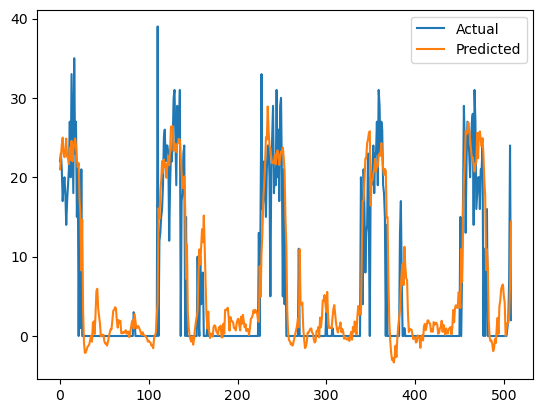

In [5]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv("datasets/weekly_scoring.csv")

# filter only QB
data = data[data['POS'] == 'qb']

# Assuming you have a date column and columns to predict for QB only
date_column = "DATE"
columns_to_predict = ['PASSING CMP', 'PASSING ATT', 'PASSING PCT', 'PASSING YDS', 'PASSING Y/A', 'PASSING TD', 'PASSING INT',
        'PASSING SACKS', 'RUSHING ATT', 'RUSHING YDS', 'RUSHING TD', 'MISC FL', 'WEEK', 'AVG_FPTS', 'MAX_FPTS', 'MIN_FPTS', 'VAR_FPTS']


# Sort the data by the date column
data[date_column] = pd.to_datetime(data[date_column])
data = data.sort_values(by=date_column)

# Extract the relevant columns for training
training_data = data[columns_to_predict].values

# Impute missing values for training_data
# Handling missing values in numeric columns using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can change the strategy as needed
training_data = imputer.fit_transform(training_data)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
training_data_scaled = scaler.fit_transform(training_data)

# Define a function to create LSTM datasets
def create_lstm_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

# Set the number of time steps to look back
look_back = 25  # You can adjust this value based on the characteristics of your data

# Create the LSTM dataset
X, Y = create_lstm_dataset(training_data_scaled, look_back)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Reshape the input data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[2]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=len(columns_to_predict)))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=2)

# Make predictions on the test set
predictions = model.predict(X_test)

# Rescale the predictions to the original scale
predictions_rescaled = scaler.inverse_transform(predictions)
Y_test_rescaled = scaler.inverse_transform(Y_test)

# Evaluate the model
# mse = mean_squared_error(Y_test_rescaled, predictions_rescaled)
# print(f'Mean Squared Error: {mse}')

#Plot the results for one of the columns
column_index = 0  # You can change this index based on the column you want to visualize
plt.plot(Y_test_rescaled[:, column_index], label='Actual')
plt.plot(predictions_rescaled[:, column_index], label='Predicted')
plt.legend()
plt.show()
